# Classification

<br/>
<br/>
<center>
<img src="images/linearly_separable.png" width="800">
</center>

This lecture will discuss basic types of classification algorithms and considerations for assessing and improving their accuracy. The focus will be on generalized linear models for discrimination of datapoints, and several other types of classification will be briefly explored.

* Classification basics
    - Problem statement for classification
    - Types of classification problems
    - Accuracy metrics

* Generalized linear models
    - Perceptron
    - Logistic regression
    - Support vector machines
    - Kernel SVMs

* Other classification models
    - Linear Discriminant Analysis
    - Naive Bayes
    - k-Nearest Neighbors
    - Decision trees and random forests

## Classification basics

### Problem statement for classification

A model that maps continuous or discrete inputs to a discrete (ordinal, categorical, or integer) output space.

There are two basic approaches to this problem:

#### Discriminative models:

These models are most similar to regression. Rather than learning a line\model that best represents the data we want to learn a line\model that best separates (discriminates) between different classes. For a binary classifier we can write this as:

$f(\vec{x}) > p$ if class 1

$f(\vec{x}) < p$ if class 2

where $p$ is some constant threshold that separates the classes.

Another way to think of this is that we will establish a function that estimates the probability of a point belonging to a particular class, given its features:

$P(y_i|\vec{x}) = f(\vec{x})$

Then the classes can be discretized by establishing probability cutoffs. These models **directly** solve the problem of estimating class probability.

#### Generative models

Generative models are somewhat less intuitive, but can be very powerful. In a generative model the goal is to solve the "inverse problem" of predicting the probability of features given a class label output. Mathematically:

$P(\vec{x}|y_i) = f(\vec{x})$

This is is counter-intuitive, but the model can then be used in conjunction with Bayes' rule to **indirectly** solve the classification problem. Bayes rule is:

$P(A|B) = \frac{P(B|A) P(A)}{P(B)} \rightarrow P(y_i|\vec{x}) = \frac{P(\vec{x}|y_i) P(y_i)}{P(\vec{x})}$

The $P(y_i)$ term is available from the data (number of times each class appears) and the $P(\vec{x})$ term is a constant so it can be dropped when computing relative probabilities.

Generative models are more difficult to understand, but they have a key advantage: new synthetic data can be generated by using the function $P(\vec{x}|y_i)$. This opens the possibility of iterative training schemes that systematically improve the estimate of $P(\vec{x}|y_i)$ (e.g. Generative Artificial Neural Networks) and can also aid in diagnosing problems in models. We will only briefly discuss generative models in this lecture.

<br>
<center>
<img src="images/discriminative_vs_generative.png" width="800">
</center>

### Features of classification problems

There are a few different types/features of classification problems:

* **Linearly separable**: A problem where it is possible to exactly separate the classes with a straight line (or plane) in the feature space.

<center>
<img src="images/linearly_separable.png" width="500">
</center>

* **Binary vs. Multi-class**: A binary classification problem has only 2 classes, while a multi-class problem has more than 2 classes. 

There are two approaches to dealing with multi-class problems:

1) Convert multi-class problems to binary problems using a series of "one vs. the rest" binary classifiers

<center>
<img src="images/OvA.png" width="400">
</center>

2) Consider the multi-class nature of the problem when deriving the method (e.g. kNN) or determining the cost function (e.g. logistic regression)

<center>
<img src="images/multiclass_cost.png" width="400">
</center>

In the end, the difference between these approaches tend to be relatively minor, although the training procedures can be quite different. One vs. the rest is more efficient for parallel training, while multi-class objective functions are more efficient in serial.

* **Balanced vs. Imbalanced**: A balanced problem has roughly equal numbers of examples in all classes, while an imbalanced problem has an (typically significantly) higher number of examples of some classes. 

There are a few basic strategies to overcome class imbalance:

1) Re-balancing the cost function to penalize mis-classification of the under-represented class more.

2) Undersampling: discarding information from over-represented class. This is inefficient since not all information is used.

<center>
<img src="images/class_imbalance.png" width="500">
</center>


3) Oversampling: add repeates of the under-represented class (very similar to re-balancing the cost function). This can lead to over-fitting of the decision boundary to the few examples of the under-represented class.

<center>
<img src="images/oversampling.png" width="500">
</center>

4) Resampling: Re-sample from the under-represented class, but add some noise. This is a robust solution, but requires some knowledge of the distribution of the under-represented data (e.g. generative models) or special techniques (e.g. SMOTE).

<center>
<img src="images/smote.png" width="500">
</center>

### Performance metrics

#### False positives and negatives

* Accuracy = (number correct)/(total) = (TP + TN)/(TP + TN + FP + FN)

* Precision = TP/(TP + FP)

* Recall = TP/(TP + FN)

<center>
<img src="images/precision_recall.png" width="500">
</center>

#### Confusion matrices

False positives and false negatives only apply to binary problems. The "confusion matrix" is a multi-class generalization of the concept, and can help identify which classes are "confusing" the algorithm.

<center>
<img src="images/confusion_matrix.png" width="500">
</center>

#### ROC curves

The "receiver operating characteristic", or ROC curve, is useful for models where a threshold is used. The area under the curve can be used as a metric for how well the model performs.

<center>
<img src="images/ROC_curve.jpg" width="300">
</center>

## Generalized Linear Models

We will work through some math and examine a toy dataset for "generalized linear" classification models. The toy dataset is simply two "blobs" that we will randomly generate using `scikit-learn`:

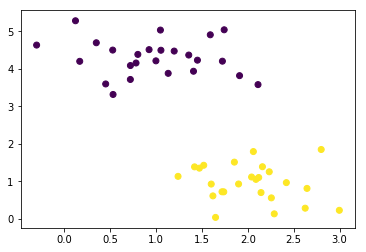

In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=50, centers=2, cluster_std=0.5, n_features=2, random_state=0)


#rescale
y_new = []
for yi in y:
    if yi == 0:
        y_new.append(-1)
    else:
        y_new.append(1)
y = np.array(y_new).reshape(y.shape)
        

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)

### The "perceptron"

We will start by considering a discrimination problem:

$f(\vec{x}) > p$ if class 1

$f(\vec{x}) < p$ if class 2

and let $f(\vec{x}) = \underline{\underline{X}}\vec{\beta}$, where $\underline{\underline{X}} = [\vec{x}, \vec{1}]$ similar to linear regression.

We can use $y$ as the output variable and arbitrarily assign "class 1" to 1 and "class 2" to -1, such that $p = 0$.

$\underline{\underline{X}}\vec{\beta} > 0$ if $y_i=1$ (class 1)

$\underline{\underline{X}}\vec{\beta} < 0$ if $y_i=-1$ (class 2)

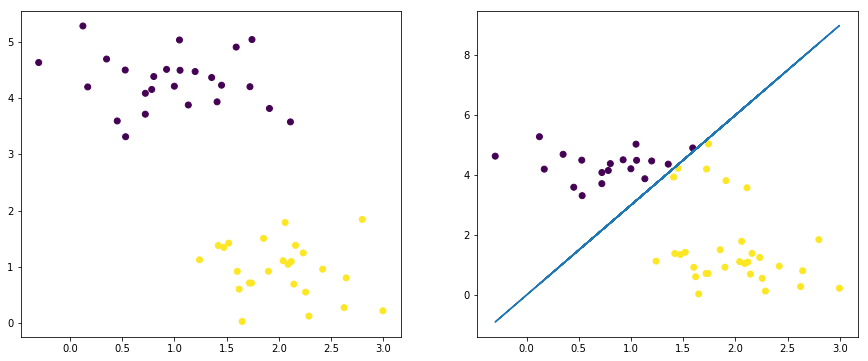

In [2]:
from  scipy.linalg  import solve

def add_intercept(X):
    intercept = np.ones((X.shape[0],1))
    X_intercept = np.append(intercept,X,1)
    return X_intercept

def linear_classifier(X,beta):
    X_intercept = add_intercept(X)
    p = np.dot(X_intercept,beta)
    return p > 0
    
beta = np.array([0,3,-1])
prediction = linear_classifier(X,beta)

fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)


#plot line
m = -beta[1]/beta[2]
b = -beta[0]/beta[2]
axes[1].plot(X[:,0], m*X[:,0]+b, ls='-')

### Derivation: Find the equation for the line

This looks a lot like linear regression, but we still need an **objective function**. This is where things get tricky. Based on the definition of $\pm$1 for classes, we can re-write this as a single line:

$-y_i \underline{\underline{X}}\vec{\beta} < 0$

Convince yourself that this is true!

Now we can turn this into an equality by taking the maximum:

$max(0, -y_i \underline{\underline{X}}\vec{\beta}) = 0$

Now we are getting close. If a point $y_i$ is mis-classified then this will give a positive value, but if it is correctly classified it will return zero. Therefore we can get a cost for the entire dataset by summing the function over all data points:

$C(\vec{\beta}) = \sum_i max(0, -y_i \underline{\underline{X}}\vec{\beta})$

and we can find the optimal $\vec{\beta}$ by minimizing it with respect to $\vec{\beta}$

This is the "max cost" function, often commonly referred to as the "perceptron" model.

In [3]:
def max_cost(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    return sum(np.maximum(0, -y*Xb))

print(max_cost(beta,X,y))

6.24866336473


#### Question: What will the optimal cost be if a dataset is linearly separable?

### Logistic Regression

There are two obvious problems with the perceptron:

1) There is a "trivial solution" at $\vec{\beta} = 0$

2) The cost function is not differentiable at all points

We can overcome the second problem by creating some smooth approximation of the maximum function. This is achieved using the "softmax" function:

$max(x,y) \approx soft(x,y) = log(exp(x) + exp(y))$

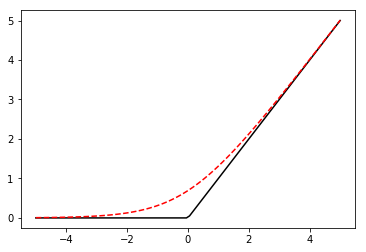

In [4]:
x = np.linspace(-5,5,100)

fig, ax = plt.subplots()

ax.plot(x, np.maximum(0,x), ls='-',color='k')
ax.plot(x, np.log(np.exp(0) + np.exp(x)), ls='--', color='r')


We can see that this also gets rid of the "trivial solution" at $\vec{\beta}=0$, so our problems are solved!

Now we can write a "softmax" cost function:

$C_{softmax}(\vec{\beta}) = \sum_i log\left\{1 + exp(-y_i \underline{\underline{X}}\vec{\beta})\right\}$

In [5]:
def softmax_cost(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    exp_yXb = np.exp(-y*Xb)
    return sum(np.log(1 + exp_yXb))

print(softmax_cost(beta,X,y))

12.7266291716


This function is differentiable, so we can minimize this with respect to $\beta$ by setting the derivative equal to zero and solving for $\beta$:

$\frac{\partial C_{softmax}}{\partial \vec{\beta}} = 0$

It turns out this problem is not fully linear, and needs to be solved iteratively using e.g. Newton's method. The math is a little more complex than before, so we won't cover it in lecture, but it is covered in Ch. 4 of "Machine Learning Refined" if you are interested. This approximation is called **logistic regression**.

The key concept to understand is that $\vec{\beta}$ is determined by minimizing the softmax cost function. We can do this numerically for our toy model:

3.62141509401e-06
0.0


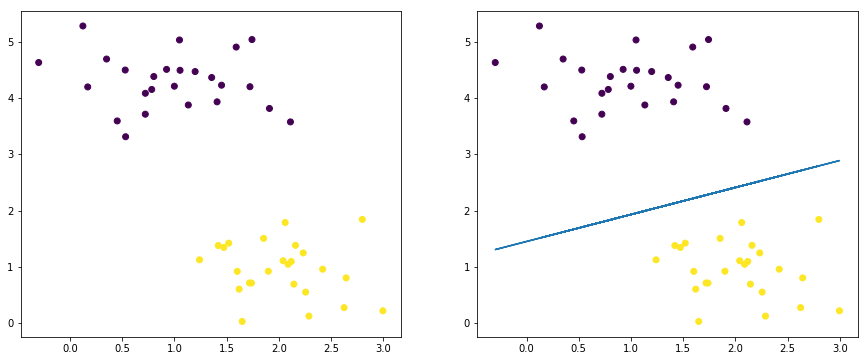

In [6]:
from scipy.optimize import minimize

result = minimize(softmax_cost, beta, args=(X,y))
beta_opt = result.x
print(softmax_cost(beta_opt,X,y))
print(max_cost(beta_opt,X,y))


prediction = linear_classifier(X,beta_opt)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)


#plot line
m = -beta_opt[1]/beta_opt[2]
b = -beta_opt[0]/beta_opt[2]
axes[1].plot(X[:,0], m*X[:,0]+b, ls='-')

Note: There are other ways to derive "logistic regression". See Ch. 4 of ML refined for an alternative derivation.

### Support Vector Machines

Recall the two problems with the max cost function:

1) There is a "trivial solution" at $\vec{\beta} = 0$

2) The cost function is not differentiable at all points

Logistic regression uses a smooth approximation of the maximum to ensure differentiability, and the "trivial solution" goes away as a side effect.

An alternative approach is to directly eliminate the trivial solution by introducing a "margin" cost function, where we recognize that there will be some "buffer zone" between the classes:

<center>
<img src="images/margin_cost.png" width="500">
</center>

We can write this mathematically as:

$\underline{\underline{X}}\vec{\beta} \geq 1$ if $y_i=1$ (class 1)

$\underline{\underline{X}}\vec{\beta} \leq -1$ if $y_i=-1$ (class 2)

by using the same trick of multiplying by $y_i$ and taking a maximum we can write this as an equality:

$max(0, 1 -y_i \underline{\underline{X}}\vec{\beta}) = 0$

and the corresponding cost/objective function:

$C_{margin}(\vec{\beta}) = \sum_i max(0, 1-y_i \underline{\underline{X}}\vec{\beta})$

Note that this is very similar to the cost function for the perceptron, but now there is no trivial solution at $\vec{\beta} = 0$. However, we can solve this with a few approaches:

1) Use derivative-free numerical approximations

2) Replax $max$ with a differentiable function like $softmax$ or $max^2$

Let's see what happens with strategy 1:

In [7]:
def margin_cost(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    return sum(np.maximum(0, 1-y*Xb))

print(margin_cost(beta,X,y))

14.4693272812


0.0
0.0


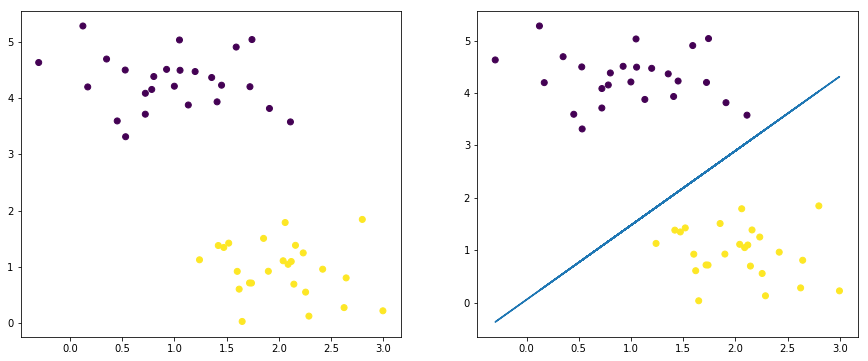

In [8]:
result = minimize(margin_cost, beta, args=(X,y))
beta_opt_margin = result.x
print(margin_cost(beta_opt_margin,X,y))
print(max_cost(beta_opt_margin,X,y))

prediction = linear_classifier(X,beta_opt_margin)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)

#plot line
m = -beta_opt_margin[1]/beta_opt_margin[2]
b = -beta_opt_margin[0]/beta_opt_margin[2]
axes[1].plot(X[:,0], m*X[:,0]+b, ls='-')

It works, but we get a different solution from logistic regression. Let's see how this compares to the $max^2$ and $softmax$ approximations:

In [9]:
def margin_cost_squared(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    return sum(np.maximum(0, 1-y*Xb)**2)

def margin_cost_softmax(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    exp_yXb = np.exp(1-y*Xb)
    return sum(np.log(1 + exp_yXb))

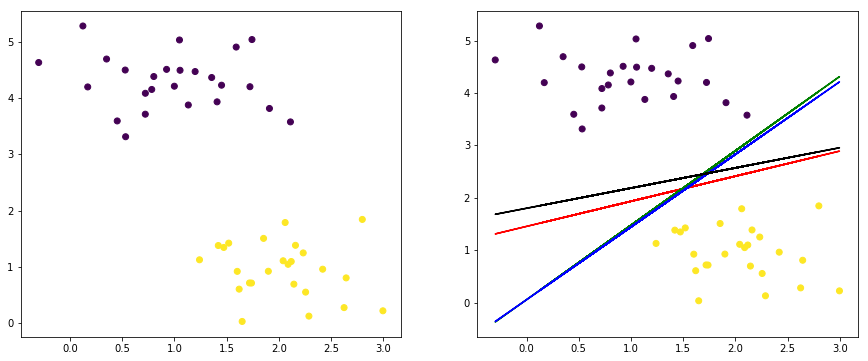

In [10]:
result = minimize(margin_cost_squared, beta, args=(X,y))
beta_opt_margin2 = result.x

result = minimize(margin_cost_softmax, beta, args=(X,y))
beta_opt_softmax = result.x

prediction = linear_classifier(X,beta_opt)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)

#plot lines
def plot_line(ax, color, beta, X):
    m = -beta[1]/beta[2]
    b = -beta[0]/beta[2]
    ax.plot(X[:,0], m*X[:,0]+b, ls='-', color=color)

for beta_i, color in zip([beta_opt,beta_opt_margin, beta_opt_margin2, beta_opt_softmax],['r','g','b','k']):
    plot_line(axes[1], color, beta_i, X)

#### Which line is the best?

There are infinitely many lines that have equal cost for a linearly-separable dataset. The line that you find will depend on the approximation used, and can also depend on the initial guesses for the parameter $\beta$.

The idea of a "support vector machine" is to regularize the cost function so that the "margins" that define the buffer zone are maximized. This is intuitive since it allows the classifier to remain accurate even as data falls outside the original bounds.

<center>
<img src="images/margin_size.png" width="500">
</center>

Through geometrical arguments it is possible to prove that the width of the margin is equal to $2/||\vec{\tilde{\beta}}||_2$ where $\vec{\tilde{\beta}}$ does not include the intercept and $||.||_2$ is the 2-norm (see Ch. 4 of ML refined).

If we want to maximize the margin, then we want to minimize $||\vec{\beta}||_2$. We can achieve this by adding an $L_2$ penalty to the cost function:

$C_{SVM}(\vec{\beta}) = \sum_i max(0, 1-y_i \underline{\underline{X}}\vec{\beta}) + \lambda ||\vec{\beta}||_2 $

Support vector machines are simply an $L_2$-regularized version of the margin cost function. In practice it is common to use a smooth approximation of the margin cost function, and it is relatively simple to show that if the "softmax" approximation is used the cost function becomes very similar to that of logistic regression.

In practice, support-vector machines and $L_2$-regularized logistic regression are nearly indistinguishable and can be used interchangeably.

Let's apply this to our example dataset:

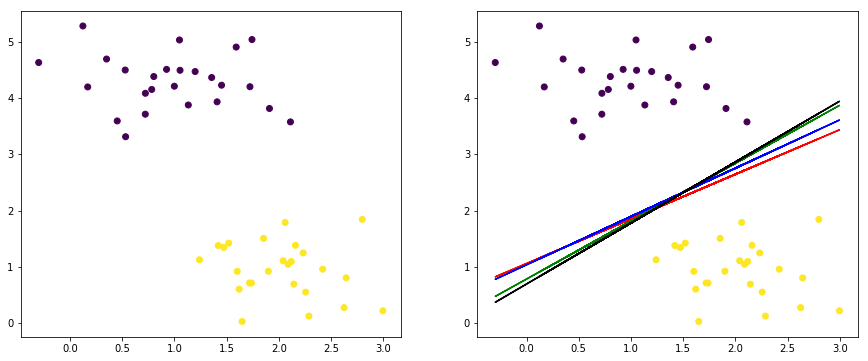

In [11]:
def regularized_cost(beta, X, y, cost_fn, lamda=1):
    cost = cost_fn(beta,X,y)
    cost += lamda*np.linalg.norm(beta,2)
    return cost
    
result = minimize(regularized_cost, beta, args=(X,y, margin_cost))
beta_SVM1 = result.x 

result = minimize(regularized_cost, beta, args=(X,y, margin_cost_softmax))
beta_SVM2 = result.x

result = minimize(regularized_cost, beta, args=(X,y, margin_cost_squared))
beta_SVM3 = result.x

result = minimize(regularized_cost, beta, args=(X,y, softmax_cost))
beta_SVM4 = result.x

prediction = linear_classifier(X,beta_SVM1)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)

for beta_i, color in zip([beta_SVM1,beta_SVM2, beta_SVM3, beta_SVM4],['r','g','b','k']):
    plot_line(axes[1], color, beta_i, X)

There are still some differences, but the results are now much closer.

#### Question: Which cost function will be worst if there are known outliers (points far from the decision boundary)?

### Kernel SVM's

The regularized cousins of the perceptron all perform similarly well as long as the classes are **linearly separable**. However, what happens if this is not the case?

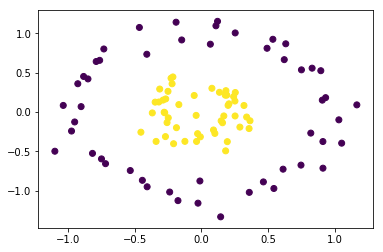

In [12]:
from sklearn.datasets.samples_generator import make_circles

X, y = make_circles(n_samples=100, factor=0.3, noise=0.1, random_state=0)


#rescale
y_new = []
for yi in y:
    if yi == 0:
        y_new.append(-1)
    else:
        y_new.append(1)
y = np.array(y_new).reshape(y.shape)
        

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)

Let's see what happens if we re-apply the SVM algorithm to this dataset:

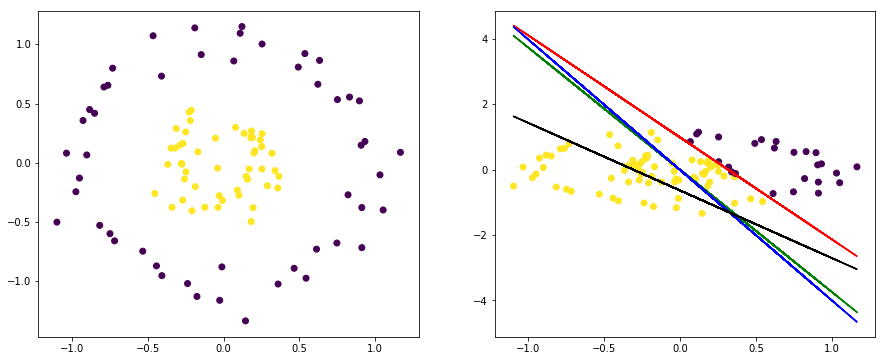

In [13]:
result = minimize(regularized_cost, beta, args=(X,y, margin_cost))
beta_SVM1 = result.x 

result = minimize(regularized_cost, beta, args=(X,y, margin_cost_softmax))
beta_SVM2 = result.x

result = minimize(regularized_cost, beta, args=(X,y, margin_cost_squared))
beta_SVM3 = result.x

result = minimize(regularized_cost, beta, args=(X,y, softmax_cost))
beta_SVM4 = result.x

prediction = linear_classifier(X,beta_SVM1)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)

for beta_i, color in zip([beta_SVM1,beta_SVM2, beta_SVM3, beta_SVM4],['r','g','b','k']):
    plot_line(axes[1], color, beta_i, X)

All the variants of the cost function fail miserably! This is because the data is not linearly separable. We can solve this using the same trick as for generalized linear regression: create new non-linear features from the original data.

For example, in this problem let's add a new feature that is a Gaussian distribution centered at (0,0) with a standard deviation of 1:

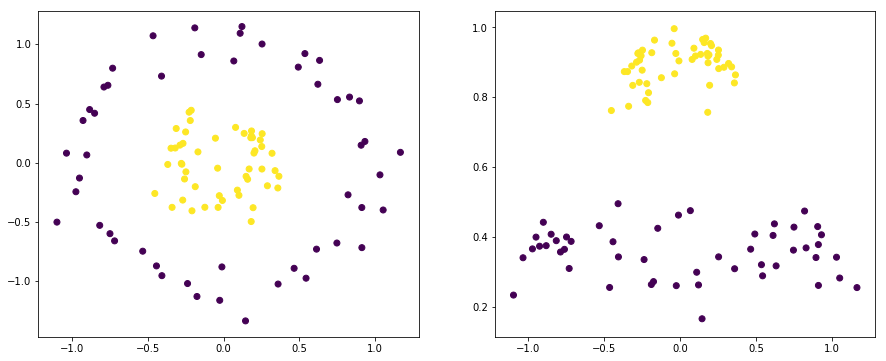

In [14]:
X_gauss = np.exp(-(X ** 2).sum(axis=1))

fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X_gauss,c=y)

Now we can add this as a feature and try again:

In [15]:
X_tot = np.append(X, X_gauss.reshape(X_gauss.size,1), axis=1)
print(X_tot.shape)

(100, 3)


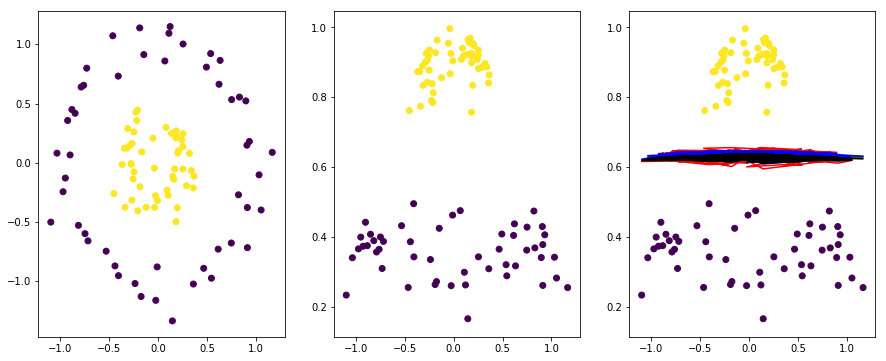

In [24]:
beta = np.ones(4)

result = minimize(regularized_cost, beta, args=(X_tot,y, margin_cost))
beta_SVM1 = result.x 

result = minimize(regularized_cost, beta, args=(X_tot,y, margin_cost_softmax))
beta_SVM2 = result.x

result = minimize(regularized_cost, beta, args=(X_tot,y, margin_cost_squared))
beta_SVM3 = result.x

result = minimize(regularized_cost, beta, args=(X_tot,y, softmax_cost))
beta_SVM4 = result.x

prediction = linear_classifier(X_tot,beta_SVM1)
fig, axes = plt.subplots(1,3,figsize=(15,6))
axes[0].scatter(X_tot[:,0],X_tot[:,1],c=y)
axes[1].scatter(X_tot[:,0],X_tot[:,2],c=y)
axes[2].scatter(X_tot[:,0],X_tot[:,2],c=prediction)


#plot lines
def plot_line_3d(ax, color, beta, X):
    m1 = -beta[1]/beta[3]
    m2 = -beta[2]/beta[3]
    b = -beta[0]/beta[3]
    ax.plot(X[:,0], m1*X[:,1] + m2*X[:,2] + b, ls='-', color=color)


for beta_i, color in zip([beta_SVM1,beta_SVM2, beta_SVM3, beta_SVM4],['r','g','b','k']):
    plot_line_3d(axes[2], color, beta_i, X_tot)

<center>
<img src="images/kernel_schematic.png" width="400">
</center>

#### Question: How did we know to center this new feature at 0? What is a more general strategy?

Just like with kernel ridge regression, we can put a Gaussian at every single point and use this as a basis. This is called a "kernel SVM" and it is the classification equivalent of ridge regression. Rather than implementing this we can use the `scikit-learn` implementation.

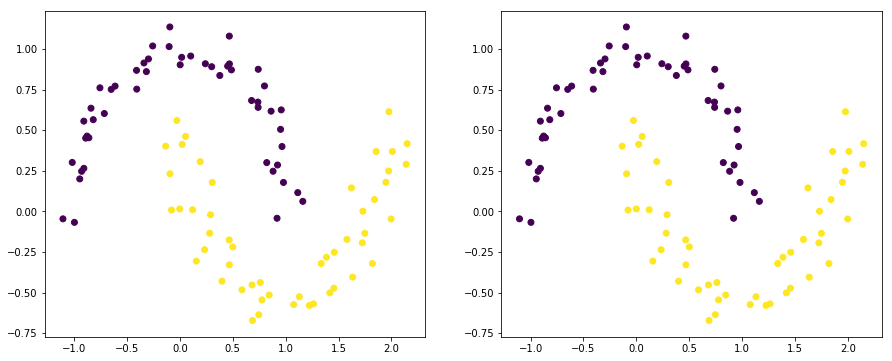

In [38]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.datasets.samples_generator import make_moons

#X, y = make_circles(n_samples=100, factor=0.3, noise=0.1)

X, y = make_moons(n_samples=100, noise=0.1)

model = SVC(kernel='rbf', gamma=0.1, C=1e10)
model.fit(X, y)
y_predict = model.predict(X)

fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=y_predict)

#### Question: How many continuous hyperparameters does the kernel SVM have?

Play around with the different datasets (circles, moons), the noise level, and the hyper-parameters of the model to get a feel for how this works under various scenarios.

## Other classification models

### Linear Discriminant Analysis

### Naive Bayes

### k-Nearest Neighbors

### Decision trees and random forests

## Further Reading

* [Machine Learning Refined - Chapter 4](http://docs.wixstatic.com/ugd/f09e45_6e2b4294ca2e46968c34071eed230d33.pdf)
* [Machine Learning Mastery: How to handle class imbalance](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)